In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter
from tqdm import tqdm
from time import time

# TODO: Move functions to separate modules
import functions as f

import core.background_model as background_model
import core.clique_finding as cf
import core.stats 

In [3]:
# GLOBALS

TTN_BIN = 4275
BIN_MAP_PATH = 'mappings/bin_map_human_100000.bed'
GTF_PATH = 'mappings/gencode.v38.annotation.gtf'
GENE_BIN_PATH = 'mappings/gene_bins.txt'
NON_GENE_BIN_PATH = 'mappings/non_gene_bins.txt'


gene_bins = []
with open('mappings/gene_bins.txt', 'r') as file:
    for line in file:
        gene_bins.append(line.strip())
gene_bins = [int(x) for x in gene_bins]


non_gene_bins = []
with open('mappings/non_gene_bins.txt', 'r') as file:
    for line in file:
        non_gene_bins.append(line.strip())
non_gene_bins = [int(x) for x in non_gene_bins]



In [4]:

def build_walk_index(contact_matrix):
    """
    Precompute for each node:
      - neighbors[i]: 1D int array of neighbors
      - cdfs[i]:      1D float array of cumulative probabilities
    """
    N = contact_matrix.shape[0]
    neighbors = [None]*N
    cdfs      = [None]*N

    for i in tqdm(range(N)):
        w = contact_matrix[i]
        idx = np.nonzero(w)[0]
        if idx.size == 0:
            neighbors[i] = np.empty(0, dtype=int)
            cdfs[i]      = np.empty(0, dtype=float)
        else:
            probs = w[idx] / w[idx].sum()
            neighbors[i] = idx
            cdfs[i]      = np.cumsum(probs)
    return neighbors, cdfs





In [5]:
contact_matrix_zero = np.load('data/hic/wildtype_100kb_zeroed.npy')
neighbors, cdfs = build_walk_index(contact_matrix_zero) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 30894/30894 [00:12<00:00, 2556.86it/s]


In [9]:
cf.find_greedy_clique(contact_matrix_zero, 5, TTN_BIN)

[4275, 30478, 25137, 30357, 29661]

Random walks: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:15<00:00, 643.89iter/s]


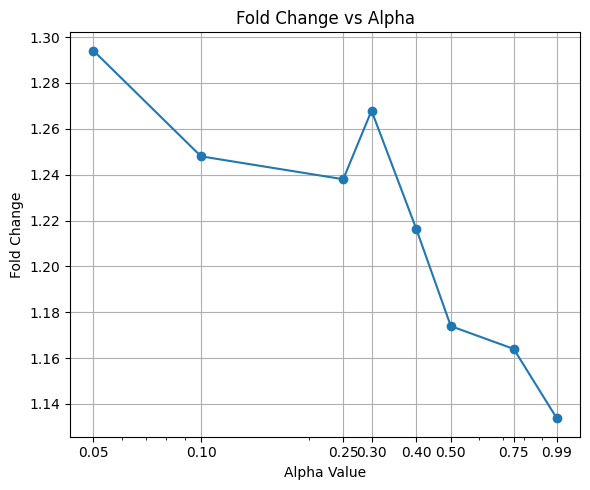

In [6]:
import functions as f
from matplotlib.ticker import ScalarFormatter
from scipy import stats

clique_size     = 5
num_iterations  = 10000
alphas          = [0.05, 0.1, 0.25, 0.3, 0.4, 0.5, 0.75, 0.99]

fold_changes = []
p_values     = []

for alpha in alphas:
    bg_strong = background_model.create_rw(
        contact_matrix_zero,
        clique_size,
        bins=gene_bins,
        label='strong',
        num_molecules=1000,
        neighbors=neighbors,
        cdfs=cdfs,
        num_iterations=num_iterations,
        alpha=alpha,
        plot=False
    )
    bg_weak = background_model.create_rw(
        contact_matrix_zero,
        clique_size,
        bins=non_gene_bins,
        label='weak',
        num_molecules=1000,
        neighbors=neighbors,
        cdfs=cdfs,
        num_iterations=num_iterations,
        alpha=alpha,
        plot=False
    )

    fold_change = np.median(bg_strong) / np.median(bg_weak)
    _, p_value  = stats.mannwhitneyu(bg_strong, bg_weak, alternative='greater')

    fold_changes.append(fold_change)
    p_values.append(p_value)


fig, ax = plt.subplots(figsize=(6, 5))

# Fold Change vs Alpha
ax.plot(alphas, fold_changes, marker='o')
ax.set_xscale('log')
ax.set_xticks(alphas)
ax.get_xaxis().set_major_formatter(ScalarFormatter())
ax.set_xlabel('Alpha Value')
ax.set_ylabel('Fold Change')
ax.set_title('Fold Change vs Alpha')
ax.grid(True)

plt.tight_layout()
plt.show()